In [1]:
# 必要なパッケージを呼び出す
using Printf
using NLsolve
using Interpolations
using Plots
using Random
using Distributions
using LaTeXStrings

In [2]:
# MATLABではグローバル変数を使って関数への変数受け渡しを行う
# Julia/Pythonではコンストラクタを用いる

# ギリシャ文字の使用は不可とする
struct Model{TI<:Integer, TF<:AbstractFloat}

    # カリブレーション
    beta::TF            # 割引因子
    gamma::TF           # 相対的危険回避度(異時点間の代替の弾力性の逆数)
    alpha::TF           # 資本分配率
    delta::TF           # 固定資本減耗(delta=1.0のときは解析解が存在)  

    # 定常状態の値
    ykss::TF
    kss::TF
    yss::TF
    css::TF    
    
    # STEP 1(a): グリッド生成
    kmax::TF            # 資本グリッドの最大値
    kmin::TF            # 資本グリッドの最小値
    nk::TI              # グリッドの数
    kgrid::Array{TF,1}  # 資本グリッド(kではなく、k'についてグリッドをとる)
    
    nz::TI
    rho::TF
    sigma::TF
    s::TF               # MATLABコードでのmに対応
    zgrid::Array{TF,1}
    Pz::Array{TF,2}

    # 時間反復法に関するパラメータ
    maxiter::TI         # 繰り返し計算の最大値
    tol::TF             # 許容誤差 (STEP 2)

end

In [3]:
function mu_CRRA(cons,gamma)
    """
    --------------------------
    === CRRA型限界効用関数 ===
    --------------------------
    <inputs>
    ・cons: 消費量
    ・gamma: 相対的リスク回避度(異時点間の代替弾力性の逆数)
    <output>
    ・consとgamma の下での限界効用水準
    """

    mu = cons.^(-gamma)

    return mu
end

mu_CRRA (generic function with 1 method)

In [4]:
function tauchen(N,mu,rho,sigma,m)
    """
    ---------------------------------------------------
    === AR(1)過程をtauchenの手法によって離散化する関数 ===
    ---------------------------------------------------
    ※z'=(1-ρ)μ + ρ*z + ε, ε~N(0,σ_{ε}^2) を離散化する

    <input>
    ・N: 離散化するグリッドの数
    ・mu: AR(1)過程の定数項(上式のμ)
    ・rho: AR(1)過程の慣性(上式のρ)
    ・sigma: AR(1)過程のショック項の標準偏差(上式のσ_{ε})
    ・m: 離散化するグリッドの範囲に関するパラメータ
    <output>
    ・Z: 離散化されたグリッド
    ・Zprob: 各グリッドの遷移行列
    """
    Zprob = zeros(N,N) # 遷移確率の行列
    c = (1-rho)*mu # 定数項

    # 等間隔のグリッドを定める
    # 最大値と最小値
    zmax = m*sqrt(sigma^2/(1-rho^2))
    zmin = -zmax
    # グリッド間の間隔
    w = (zmax-zmin)/(N-1)

    Z  = collect(range(zmin,zmax,length=N))
    # 定常状態はmu(E[Z]=mu)
    Z .+= mu

    # グリッド所与として遷移確率を求める
    for j in 1:N # 今期のZのインデックス
        for k in 1:N  # 来期のZのインデックス
            if k == 1
                Zprob[j,k] = cdf_normal((Z[k]-c-rho*Z[j]+w/2)/sigma)
            elseif k == N
                Zprob[j,k] = 1 - cdf_normal((Z[k]-c-rho*Z[j]-w/2)/sigma)
            else
                Zprob[j,k] = cdf_normal((Z[k]-c-rho*Z[j]+w/2)/sigma) - cdf_normal((Z[k]-c-rho*Z[j]-w/2)/sigma)
            end
        end
    end

    return Z,Zprob 
end

tauchen (generic function with 1 method)

In [5]:
function cdf_normal(x)
    """
    --------------------------------
    === 標準正規分布の累積分布関数 ===
    --------------------------------
    <input>
    ・x: 
    <output>
    ・c: 標準正規分布にしたがう確率変数Xがx以下である確率
    """
    d = Normal(0,1) # 標準正規分布
    c = cdf(d,x)

    return c
    
end

cdf_normal (generic function with 1 method)

In [6]:
function EulerEq_stoch(m,x,wealth,cfcn,Pzvec)
    """
    ----------------------------------------------
    === オイラー方程式に代入した際の残差を返す関数 ===
    ----------------------------------------------
    <input>
    ・m: パラメータ等を含む構造体
    ・x: 今期の消費水準 (find_zero関数の利用上ベクトル表記する)
    ・wealth: 今期の資産水準 (f(k,z))
    ・cfcn: 消費関数(nk*nz)
    ・Pz_vec: 今期のzを所与としたときの、来期のz'への遷移ベクトル
    """
    cons = x[1];
    kprime = wealth - cons;
    # トリック: k'は正の値しか取らない
    kprime = max(m.kgrid[1],kprime);

    # 右辺の期待値を計算
    #  A_{t+1}=A_{j} for j=1,...,nzのそれぞれについて、条件付き確率で加重平均をとることで期待値を計算する
    RHS = 0.0;
    for jz in 1:m.nz

        # 次期の政策関数を線形補間
        interp_c = LinearInterpolation(m.kgrid,cfcn[:,jz],extrapolation_bc=Throw());
        cnext = interp_c(kprime);
        # 条件付き確率で加重平均
        RHS += Pzvec[jz] * mu_CRRA(cnext,m.gamma) * (m.alpha*exp(m.zgrid[jz])*kprime.^(m.alpha-1) + (1 .-m.delta));

    end

    # オイラー方程式の残差を求める（u'(c)をmu_CRRA関数を用いて計算している）
    res = mu_CRRA(cons,m.gamma) - m.beta*RHS

    return res
end

EulerEq_stoch (generic function with 1 method)

### 確率的なモデルでの時間反復法 
(MATLAB の main_ti_stoch.m に対応)

In [7]:
# メインファイル

# カリブレーション
beta = 0.99;  # 割引因子
gamma = 1.0;  # 相対的リスク回避度(異時点間の代替の弾力性の逆数)
alpha = 0.36; # 資本分配率
delta = 0.025;  # 固定資本減耗(delta=1.0のときは解析解が存在)

# 定常状態の値
ykss = (1.0/beta-1.0+delta)/alpha;
kss = ykss^(1.0/(alpha-1.0));
yss = ykss*kss;
css = yss-delta*kss;

# STEP 1(a): グリッド生成 
kmax = 1.5*kss;   # 資本グリッドの最大値
kmin = 0.1*kss;   # 資本グリッドの最小値(0にすると生産が出来なくなる)
nk = 21;          # グリッドの数
kgrid = collect(range(kmin,kmax,length=nk));

nz = 11;
rho = 0.95;
sigma = 0.01;
s = 2.575;
zgrid,Pz = tauchen(nz,0.0,rho,sigma,s)

# 時間反復法に関するパラメータ
maxiter = 1000; # 繰り返し計算の最大値
tol = 1e-5;     # 許容誤差(STEP 2)

In [8]:
# 収束の基準に関するパラメータ
it = 1;         # ループ・カウンター
dif2 = 1.0;     # 政策関数の繰り返し誤差
tolfun = 1e-10; # 最適化の許容誤差

# 構造体にパラメータを格納
m = Model(beta,gamma,alpha,delta,ykss,kss,yss,css,kmax,kmin,nk,kgrid,nz,rho,sigma,s,zgrid,Pz,maxiter,tol);

println("-+- Solve a neoclassical growth model with time iteration -+-")

# STEP 1(b): 政策関数の初期値を当て推量
cfcn0 = (css/kss)*m.kgrid*ones(1,m.nz);
cfcn1 = zeros(m.nk,m.nz);

# 繰り返し計算誤差を保存する変数を設定
dif = zeros(2,maxiter);

# STEP 4: 政策関数を繰り返し計算
@time while (it < m.maxiter) && (dif2 > m.tol)

    for iz in 1:m.nz

        technology = exp(m.zgrid[iz]);
        Pzvec = Pz[iz,:];

        for ik in 1:m.nk

            capital = m.kgrid[ik];
            wealth = technology*capital.^m.alpha + (1 .- m.delta).*capital;

            # Juliaの最適化関数(nlsolve)を使って各グリッド上の政策関数の値を探す
            # 最適化の初期値は古い政策関数の値
            res = nlsolve(x->EulerEq_stoch(m,x,wealth,cfcn0,Pzvec),[cfcn0[ik,iz]],ftol=tolfun);
            cons = res.zero[1];
            cfcn1[ik,iz] = cons;
            kprime = wealth - cons;

        end
    end

    # 繰り返し計算誤差を確認
    dif2 = maximum(abs.(cfcn1-cfcn0));

    # 収束途中の繰り返し計算誤差を保存
    dif[2,it] = dif2;

    # 政策関数をアップデート
    cfcn0 = copy(cfcn1);

    @printf "iteration index: %1d \n" it  
    @printf "policy function iteration error: %1.6f \n" dif2 
    flush(stdout)

    it += 1

end

-+- Solve a neoclassical growth model with time iteration -+-
iteration index: 1 
policy function iteration error: 0.072915 
iteration index: 2 
policy function iteration error: 0.062951 
iteration index: 3 
policy function iteration error: 0.054754 
iteration index: 4 
policy function iteration error: 0.047907 
iteration index: 5 
policy function iteration error: 0.042123 
iteration index: 6 
policy function iteration error: 0.037195 
iteration index: 7 
policy function iteration error: 0.032964 
iteration index: 8 
policy function iteration error: 0.029309 
iteration index: 9 
policy function iteration error: 0.026134 
iteration index: 10 
policy function iteration error: 0.023362 
iteration index: 11 
policy function iteration error: 0.020932 
iteration index: 12 
policy function iteration error: 0.018793 
iteration index: 13 
policy function iteration error: 0.016903 
iteration index: 14 
policy function iteration error: 0.015229 
iteration index: 15 
policy function iteration erro

In [9]:
# consumption path
# simulation
# generate exogenous shock sequence

T = 1000;
ivec = zeros(Int64,T+1);
ivec[1] = 3;

# 条件付き累積密度関数: i列の要素の累積和
cumP = cumsum(m.Pz,dims=2)

for t in 1:T

    cumPi = cumP[ivec[t],:];
    # 一様分布から[0,1]の値をとる乱数を発生させ、条件付き累積密度関数と比較する
    # たとえば、rand<cumPi(1)のとき、ivec(t+1)=1となる
    rand1 = rand(Uniform(0,1));
    ivec[t+1] = sum(rand1 .- cumPi .>= 0) + 1;
    ivec[t+1] = min(ivec[t+1],m.nz);

end


cvec = zeros(T);
kvec = zeros(T+1);
kvec[1] = kss;

for t in 1:T

    iz = ivec[t];
    know = kvec[t];
    c_interp = LinearInterpolation(m.kgrid,cfcn0[:,iz],extrapolation_bc=Throw());
    cnow = c_interp(know);
    kprime = exp(m.zgrid[iz])*know^m.alpha + (1-m.delta)*know - cnow;
    cvec[t] = cnow;
    kvec[t+1] = kprime;

end

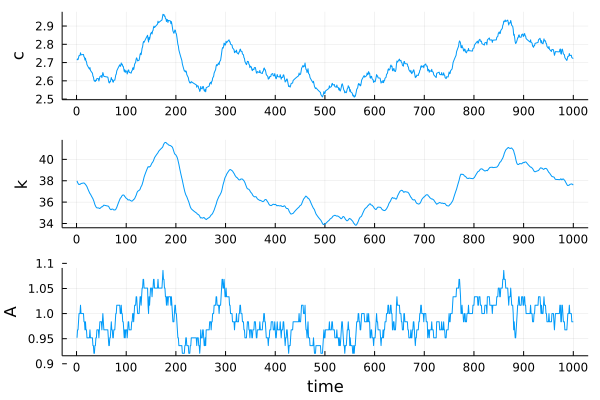

In [10]:
p1 = plot(cvec,ylabel="c",yticks=([2.5,2.6,2.7,2.8,2.9],[2.5,2.6,2.7,2.8,2.9]));
p2 = plot(kvec[1:T],ylabel="k",yticks=([34,36,38,40],[34,36,38,40]));
p3 = plot(exp.(m.zgrid[ivec[1:T]]),xlabel="time",ylabel="A",yticks=([0.9,0.95,1,1.05,1.1],[0.9,0.95,1,1.05,1.1]));

plot(p1,p2,p3,layout=(3,1),legend=false,xticks=(0:100:1000,0:100:1000))
#savefig("TI_stochsim.pdf")

In [11]:
# 政策関数を図示する(main_ti_stoch_result.m)
pfcn = zeros(m.nk,m.nz);
for j in 1:m.nz

    pfcn[:,j] .= exp(zgrid[j])*m.kgrid.^m.alpha + (1-m.delta)*m.kgrid - cfcn0[:,j];

end

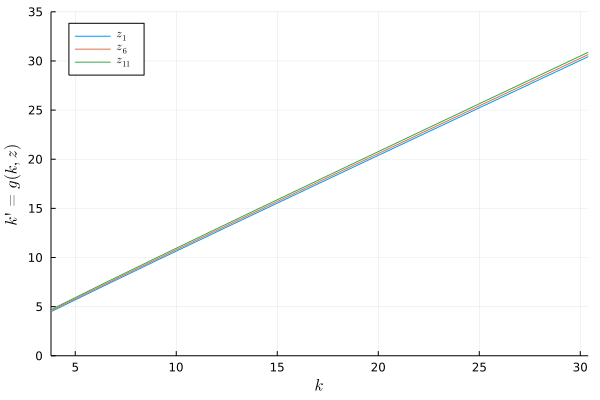

In [12]:
plot(m.kgrid,pfcn[:,1],label=L"z_{1}",legend=:topleft)
plot!(m.kgrid,pfcn[:,6],label=L"z_{6}")
plot!(m.kgrid,pfcn[:,11],label=L"z_{11}")
xlabel!(L"k")
ylabel!(L"k'=g(k,z)")
xlims!(m.kgrid[1],m.kgrid[11])
ylims!(0.0,35.0)